# PokerAgent
The following code is the agent of Poker Game. There are two different way to draw cards.<br>
(1)  Uniform:  Each card has the same probability.<br>
(2) Optional:  The cards with 10 points have less probability.<p>
There are three different action.<br>
<b>Hit Stand Double<b>

In [1]:
# Envrionment
# The code is form gym PokerAgent example
# Chin-Wei Wang add function double and split card 2019/5/22
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1 = Ace, 2-10 = Number cards, Jack/Queen/King = 10
deck = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
p=0.09
probability = [p,p,p,p,p,p,p,p,p,p,0.10,0,0]

def cmp(a, b):
    # when a > b return 1; when a < b return -1;when a == b return 0
    return int((a > b)) - int((a < b))

def draw_card_uniform():
    return random.sample(deck, 1)[0]

def draw_card_non_uniform():
    return np.random.choice(deck, 1, p=probability)[0]

# Ace
# return true if the ace is usable
def usable_ace(hand):
    return 1 in hand and sum(hand) + 10 <= 21

def sum_hand(hand):
    if usable_ace(hand):
        return sum(hand) + 10
    return sum(hand)

def is_bust(hand):
    return sum_hand(hand) > 21

def score(hand):
    return 0 if is_bust(hand) else sum_hand(hand)

def is_natural(hand):
    return sorted(hand) == [1, 10]

def is_duplicated(hand):
    if np.size(hand) == 2:
        return hand[0] == hand[1]
    return False

# action(0, 1, 2)     -> (stay, hit, double)
# action(0, 1, 2, 3) -> (stay, hit, double, surrender)

class PokerAgent:
    def __init__(self, natural=True):
        self.action_size = 1
        self.state_size = [1, 3]
        self.natural = natural
        self.uniform = True
        self.duplicated = False
        self.Surrender = False
        self.player = []
        self.dealer = []
        self.reset()

    def step(self, action):
        # Split
        if is_duplicated(self.player) and self.duplicated:
            duplicate = self.player.pop(1)
            if self.uniform:
                self.player.append(draw_card_uniform())
            else:
                self.player.append(draw_card_non_uniform())
            done = True
            
            rewards = 0
            if is_bust(self.player):  
                reward = -1
            else:
                while sum_hand(self.dealer) < 17:
                    if self.uniform:
                        self.dealer.append(draw_card_uniform())
                    else:
                        self.dealer.append(draw_card_non_uniform())
                reward = cmp(score(self.player), score(self.dealer))     
            
            self.player=[]
            self.player.append(duplicate)
            
            if self.uniform:
                self.player.append(draw_card_uniform())
            else:
                self.player.append(draw_card_non_uniform())
                
            if is_bust(self.player):   
                reward = reward-1
            else:
                while sum_hand(self.dealer) < 17:
                    if self.uniform:
                        self.dealer.append(draw_card_uniform())
                    else:
                        self.dealer.append(draw_card_non_uniform())
                reward = cmp(score(self.player), score(self.dealer)) + reward
        else:
            # stand
            if action == 0:
                done = True
                # dealer's turn
                while sum_hand(self.dealer) < 17:
                    if self.uniform:
                        self.dealer.append(draw_card_uniform())
                    else:
                        self.dealer.append(draw_card_non_uniform())
                reward = cmp(score(self.player), score(self.dealer))
                if self.natural and is_natural(self.player) and reward == 1:
                    reward = 1.5

            # hit
            elif action == 1:
                if self.uniform:
                    self.player.append(draw_card_uniform())
                else:
                    self.player.append(draw_card_non_uniform())               

                if is_bust(self.player):
                    done = True
                    reward = -1
                else:
                    done = False
                    reward = 0

            # double down
            elif action == 2:
                if self.uniform:
                    self.player.append(draw_card_uniform())
                else:
                    self.player.append(draw_card_non_uniform()) 
                done = True
                if is_bust(self.player):
                    reward = -1 * 2
                # dealer's turn
                else:
                    while sum_hand(self.dealer) < 17:
                        if self.uniform:
                            self.dealer.append(draw_card_uniform())
                        else:
                            self.dealer.append(draw_card_non_uniform())
                    reward = cmp(score(self.player), score(self.dealer)) * 2
        
            # Surrender
            else:
                done = True
                reward = -0.5
                
        return self.get_obs(), reward, done, {}

    def get_obs(self):
        return [sum_hand(self.player), self.dealer[0], usable_ace(self.player)]

    def reset(self):
        self.player = []
        self.dealer = []
        if self.uniform:
            self.dealer.append(draw_card_uniform())
            self.player.append(draw_card_uniform())
            self.player.append(draw_card_uniform())
        else:
            self.dealer.append(draw_card_non_uniform())
            self.player.append(draw_card_non_uniform())
            self.player.append(draw_card_non_uniform())
        return self.get_obs()

# Human Policy
In geneal, when the total points of hand cards reach to 17, we don't ask card anymore

In [2]:
# Policy
# action(0, 1, 2) -> (stay, hit, double)
def human_policy(env):
    if sum_hand(env.player) < 17 and sum(env.dealer) > 8:
        action = 1   # double
    elif sum_hand(env.player) < 17:
        action = 1   # hit
    else:
        action = 0  # stay
    observation,reward,done,_ = env.step(action)
    return action,observation,reward,done

def random_policy(env):
    action = np.random.randint(0,4)
    observation,reward,done,_ = env.step(action)
    return action,observation,reward,done

def optimize_policy(env):
    if sum_hand(env.player) < 8:
        action = 1   # hit
    elif sum_hand(env.player) < 17 and sum(env.dealer) > 6:
        action = 1   # hit
    elif sum_hand(env.player) < 17 and sum(env.dealer) == 1:
        action = 1   # hit
    elif sum_hand(env.player) < 12 and sum(env.dealer) < 4 :
        action = 1   # hit
    elif sum_hand(env.player) == 11:
        action = 2   # double
    elif sum_hand(env.player) == 10 and sum(env.dealer) < 10 and sum(env.dealer) > 1:
        action = 2   # double
    elif sum_hand(env.player) == 9 and sum(env.dealer) < 7 and sum(env.dealer) > 2:
        action = 2   # double
    else:
        action = 0   # stay

    observation,reward,done,_ = env.step(action)
    return action,observation,reward,done

In [3]:
def print_card(i_time,env):
    print(f"Game Set : {i_time}")
    print(f"Player Card : {env.player}")
    print(f"Is Bust : {is_bust(env.player)}")
    print(f"Dealer Card : {env.dealer}")

def print_result(i_times,actions,results,money_):
    print(f"Total : {i_times} times")
    print(f"stay : {actions.count(0)} , hit : {actions.count(1)} , double : {actions.count(2)}")
    print(f"Player win: {results.count(2)+results.count(1.5)+results.count(1)} Player double win: {results.count(2)}")
    print(f"Dealer win: {results.count(-1)+results.count(-2)} Dealer double win: {results.count(-2)}")
    print(f"Tie : {results.count(0)}")
    print(f"Money : {money_} ")
    print(f"Expection value : {money_/i_times} ")
    print()

# Human Policy Game Loop
There are three different policy.<br>
(1) Random Policy<br>
(2) Human Policy<br>
(3) Optimize Policy

In [4]:
each_print = False
# Play the game
def game_loop(game_times,step_times):
    env = PokerAgent()
    results = []
    actions = []
    money = []
    money_ = 0
    for i in range(1,game_times+1):
        for j in range(step_times):
            state = env.reset()
            done = False
            while done == False:
                #action,observation,reward,done = human_policy(env)
                #action,observation,reward,done = random_policy(env)
                action,observation,reward,done = optimize_policy(env)
                actions.append(action)
            results.append(reward)
            money_ += reward
            money.append(money_)
        if each_print and i % step_times == 0:
            print_result(i*step_times,actions,results,money_)

    print_result(i*step_times,actions,results,money_)
    fig = plt.figure()
    plt.plot(np.arange(1,game_times),money[1:game_times])
    plt.ylabel('Money')
    plt.xlabel('Episode')
    plt.grid()
    plt.show()


Total : 100000 times
stay : 79407 , hit : 60614 , double : 3238
Player win: 42279 Player double win: 1883
Dealer win: 48431 Dealer double win: 1145
Tie : 9290
Money : -3361.5 
Expection value : -0.033615 



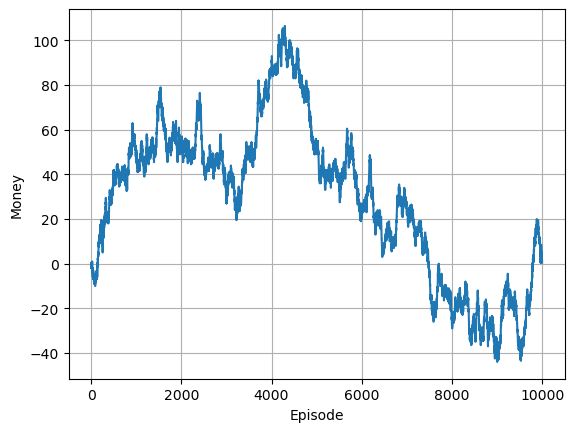

In [5]:
game_loop(10000,10)

# Deep Q-Learning Agent

In [6]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from collections import deque

# Deep Q-learning Agent
class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95         # discount rate
        self.epsilon = 1.0            # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def replay(self):
        minibatch = self.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                target = (reward + self.gamma *
                          np.amax(self.target_model.predict(next_state)[0]))           
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_model(self, total_step):
          if total_step % 10 == 0:      # %10
                weights = self.model.get_weights()
                target_weights = self.target_model.get_weights()
                for i in range(len(target_weights)):
                    target_weights[i] = weights[i]
                self.target_model.set_weights(target_weights)
                
    def save(self, file):
        self.model.save_weights(file)

    def load(self, file):
        self.model.load_weights(file)


# Double Deep Q-Learning Agent

In [7]:
from keras.models import Model, Sequential
from keras.layers import Dense, Input
from keras.optimizers import Adam
from collections import deque

# Double Deep Q-learning Agent
class DDQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.batch_size = 64
        self.memory = deque(maxlen=10000)
        self.gamma = 0.95         # discount rate
        self.epsilon = 1.0        # exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.model = self.build_model()
        self.target_model = self.build_model()
        
    def build_model(self):
        # Neural Net for Double Deep-Q learning Model
        model = Sequential()
        model.add(Dense(128, input_dim=self.state_size, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        return model
    
    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])  # returns action
    
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def replay(self):
        minibatch = self.sample(self.batch_size)
        for state, action, reward, next_state, done in minibatch:
            target = reward
            if not done:
                predicted_action = np.argmax(self.model.predict(next_state)[0])                
                target = reward + self.gamma * self.target_model.predict(next_state)[0][predicted_action]         
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state, target_f, epochs=1, verbose=0)
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
    
    def update_model(self, total_step):
          if total_step % 10 == 0:      # %10
                weights = self.model.get_weights()
                target_weights = self.target_model.get_weights()
                for i in range(len(target_weights)):
                    target_weights[i] = weights[i]
                self.target_model.set_weights(target_weights)
                
    def save(self, file):
        self.model.save_weights(file)

    def load(self, file):
        self.model.load_weights(file)



# Training Agent

In [ ]:
env = PokerAgent()
state_size_,action_size_ = 3, 4    # 3,4
dqn_agent = DDQNAgent(state_size_, action_size_)
#dqn_agent = DDQNAgent(state_size_, action_size_)
# dqn_agent.load('poke_model_per_d.h5')
n_episode = 15000
n_steps = 10
stand, hit, double, surrender = 0, 0, 0, 0
bj_win = 0
money = 0
capacity = 10000
cur_money = money
total_step = 0
mon = []
# start training
for episode_i in range(n_episode):
    cur_state_ = env.reset()
    for step_i in range(n_steps):
        total_step += 1
        cur_state_ = np.reshape(cur_state_, [1, dqn_agent.state_size])
        if total_step > capacity:
            action = dqn_agent.act(cur_state_)
        else:
            action = np.random.randint(0, 4)    # (0,3)
        if action == 0:
            stand += 1
        elif action == 1:
            hit += 1
        elif action == 2:
            double += 1
        elif action ==3:
            surrender +=1
            
        observation, reward_, done_, _ = env.step(action)
        observation = np.reshape(observation, [1, dqn_agent.state_size])
        dqn_agent.remember(cur_state_, action, reward_ , observation, done_)
        if total_step > capacity:
            dqn_agent.replay()
            dqn_agent.update_model(total_step)
        cur_state_ = observation
        if done_:
            if reward_ == 1.5:
                bj_win += 1
            money += reward_
            break

    if episode_i % 100 == 0:
        money_change = money - cur_money
        mon.append(money_change)
        dqn_agent.save('poke_model_dd_u_2.h5')
        print(f"Stand {stand}")
        print(f"Hit {hit}")
        print(f"Double {double}")
        print(f"Surrender {surrender}")

        stand, hit, double, surrender = 0, 0, 0, 0
        print("Episode {}/{}, Money:{}, Epsilon:{}".format(episode_i, n_episode, money_change, dqn_agent.epsilon))
        cur_money = money
        print()
        print()
        



In [ ]:
ax = np.linspace(0,15000,num = 150)
plt.plot(ax,mon)
plt.title('Rewards',fontsize=12)
plt.grid()
plt.show()
print(bj_win)

# Reinforcement Learning Game Loop
The following code is using the Policy after Q-Learning.<br>

In [ ]:
env = PokerAgent()
state_size , action_size = 3, 4    # 3,3
dqn_agent = DDQNAgent(state_size, action_size)
#dqn_agent = DDQNAgent(state_size, action_size)

dqn_agent.load('poke_model_dd_u_2.h5') # Uniform DQNAgent

dqn_agent.epsilon  = 0
n_episode = 100000
n_steps = 5
stand, hit, double, surrender, bj_win = 0, 0, 0, 0, 0
money = 0
cur_money = money
game = []
moneys = []
for episode_i in range(n_episode):
    cur_state = env.reset()
    for step_i in range(n_steps):
        cur_state = np.reshape(cur_state, [1, dqn_agent.state_size])
        action = dqn_agent.act(cur_state)

        if action == 0:
             stand += 1
        elif action == 1:
             hit += 1
        elif action == 2:
             double += 1
        elif action == 3:
             surrender +=1
                
        observation, reward_, done_, _ = env.step(action)
        observation = np.reshape(observation, [1, dqn_agent.state_size])
        cur_state = observation
        if done_:
            if reward_ == 1.5:
                bj_win += 1
            money += reward_
            break
    if episode_i % 1000 == 0:
        money_change = money - cur_money
        game.append(money_change)
        cur_money = money
        moneys.append(money)



# Plot Result
Show the result with 

In [ ]:
print(f"Stand Rate : {stand / (stand + hit + double+surrender)}")
print(f"Hit Rate : {hit / (stand + hit + double+surrender)}")
print(f"Double Rate : {double / (stand + hit + double+surrender)}")
print(f"Surrender Rate : {surrender / (stand + hit + double+surrender)}")


print(f"Total Times  : {stand + hit + double+surrender}")
print(f"Money : {money}")
print(f"BJ Win : {bj_win}")
print(f"Expect Value of each action: {money/(stand + hit + double+surrender+bj_win)}")
print(f"Expect Value of each game: {money/(100000)}")

ax = np.linspace(0,100000,num = 100)
plt.plot(ax,game)
plt.title('Game per 1000',fontsize=12)
plt.grid()
plt.show()


plt.plot(ax,moneys)
plt.title('Total Money',fontsize=12)
plt.grid()
plt.show

# Strategy Table
Consider the steady and return the maximum probability of action

In [ ]:
n_episode = 50
Memory = []
Ace = 0
for player_card in range(2,22):
    cur_state = env.reset()
    for dealer_card in range(1,11):
        stand, hit, double, surrender = 0, 0, 0, 0
        for episode in range(n_episode):
            cur_state = np.array([[player_card, dealer_card,  0]])
            action = dqn_agent.act(cur_state)
            if action == 0:
                stand += 1
            elif action == 1:
                hit += 1
            elif action == 2:
                double += 1
            elif action == 3:
                surrender +=1
            
        steady_action = np.argmax([stand,hit,double,surrender])
        if steady_action == 0:
            Memory.append([cur_state,"Stand"])
        elif steady_action == 1:
            Memory.append([cur_state,"Hit"])
        elif steady_action == 2:
            Memory.append([cur_state,"Double"])
        elif steady_action == 3:
            Memory.append([cur_state,"Surrender"])



In [ ]:
memory_dict = {}
for mem in Memory:
    row,col = (mem[0][0][:2])
    if not col in memory_dict.keys():
        memory_dict[col] = []
    else:
        memory_dict[col].append(mem[1])
df = pd.DataFrame()
for col in memory_dict.keys():
    df[col] = memory_dict[col]
df['Player Card'] = np.arange(3, 22)

df.set_index(['Player Card'])